In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.notebook import tqdm

import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd()))

from berp.generators import thresholded_recognition
from berp.models.reindexing_regression import ModelParameters

In [103]:
item = thresholded_recognition.sample_item("In the episode, she learns that her then estranged husband is releasing a new song",
                                           recognition_threshold=torch.tensor(0.9))
X_word, X_phon, y = item[:3]

in the episode she learns that her then estranged husband is releasing a new song


In [104]:
X_word

,token,time,recognition_point,surprisal
token_idx,,,,
0,the,0.054688,0,5.385767
1,episode,1.140625,3,11.345533
2,she,2.031250,0,9.465180
3,learns,3.257812,3,9.862536
4,that,4.296875,2,1.192771
5,her,5.046875,0,3.989665
6,then,5.992188,3,12.735801
7,estranged,7.085938,3,10.160396
8,husband,8.140625,0,1.075100


In [105]:
X_phon

time phoneme  surprisal
token_idx phon_idx                              
0         0          0.054688       t   7.496534
          1          0.132812       h   7.121365
          2          0.226562       e   7.353044
1         0          0.937500       e  13.312811
          1          1.031250       p  13.309510
...                       ...     ...        ...
12        2         12.726562       w   6.760072
13        0         13.515625       s   7.243836
          1         13.578125       o   7.301001
          2         13.648438       n   7.384552
          3         13.742188       g   7.511605

[65 rows x 3 columns]

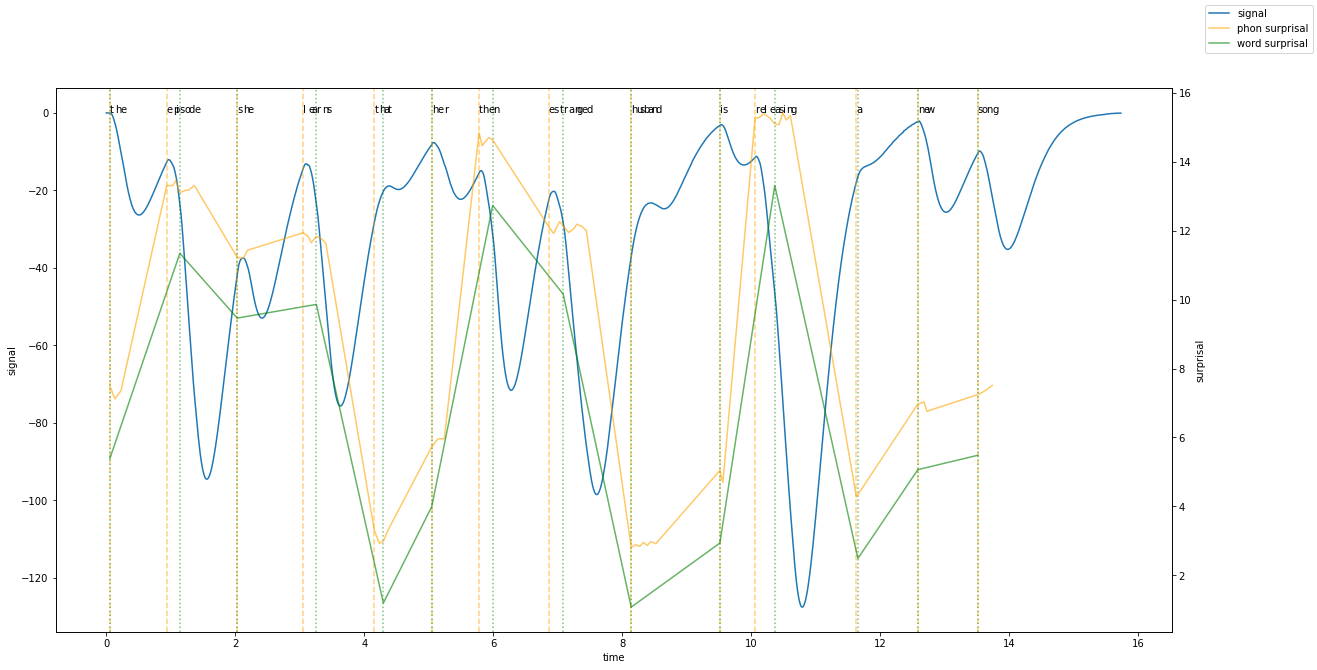

In [106]:
plt.subplots(figsize=(20, 10))
ax = sns.lineplot(data=y, x="time", y="signal")
twinx = ax.twinx()
sns.lineplot(data=X_phon, x="time", y="surprisal", color="orange", alpha=0.6, ax=twinx)
sns.lineplot(data=X_word, x="time", y="surprisal", color="green", alpha=0.6, ax=twinx)
ax.figure.legend(["signal", "phon surprisal", "word surprisal"])

word_onsets = X_phon.groupby("token_idx").apply(lambda xs: xs.iloc[0]).time
for _, phon in X_phon.iterrows():
    ax.annotate(phon.phoneme, xy=(phon.time, 0.1))
for onset in word_onsets:
    ax.axvline(onset, linestyle="--", color="orange", alpha=0.5)
for recognition_onset in X_word.time:
    ax.axvline(recognition_onset, linestyle=":", color="green", alpha=0.5)

## Generate whole dataset

In [107]:
sys.path.append("scripts")
import regression_reindexing_synth as synth
sentences = synth.generate_sentences()

In [108]:
dataset = thresholded_recognition.sample_dataset(sentences)

  0%|          | 0/22 [00:00<?, ?it/s]

alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversation
so she was considering in her own mind as well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisychain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her
there was nothing so very remarkable in that nor did alice think it so very much out of the way to hear the rabbit say to itself oh dear
oh dear
i shall be late
when she thought it over afterwards it occurred to her that she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually took a watch out of its waistcoatpocket and looked at it and then hurried on alice started to he

### N400 replication

With ground-truth recognition onset information, can we reproduce an N400 effect with ERP analysis?

In [126]:
epochs = thresholded_recognition.dataset_to_epochs(dataset.X_word, dataset.y)

  0%|          | 0/292 [00:00<?, ?it/s]

In [127]:
baseline_window = (-.1, 0)
test_window = (0.3, 0.5)
df_test = epochs.groupby(["item", "token_idx"]).apply(
    lambda rows: pd.Series({"epoch_baseline": rows[(rows.epoch_time >= baseline_window[0]) & (rows.epoch_time < baseline_window[1])].signal.mean(),
                            "epoch_value": rows[(rows.epoch_time >= test_window[0]) & (rows.epoch_time < test_window[1])].signal.mean()}))

In [128]:
merged_df = pd.merge(df_test, dataset.X_word, left_index=True, right_index=True)
merged_df["epoch_value_baselined"] = merged_df.epoch_value - merged_df.epoch_baseline

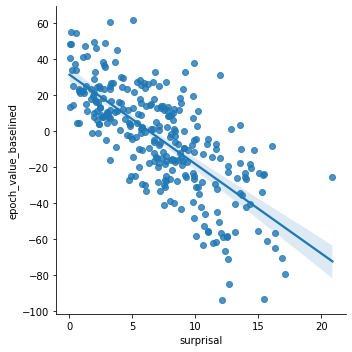

In [129]:
sns.lmplot(data=merged_df, x="surprisal", y="epoch_value_baselined")

In [130]:
st.pearsonr(merged_df.surprisal, merged_df.epoch_value_baselined)

(-0.7207986074176697, 4.4678004572559537e-48)

### N400 replication without ground truth

If we assume recognition onset happens at first phoneme onset, does the effect still show?

In [119]:
X_word_simplified = dataset.X_word.copy()
X_word_simplified["time_gt"] = X_word_simplified.time
X_word_simplified["time"] = dataset.X_phon.xs(0, level="phon_idx").time
assert (X_word_simplified.time <= X_word_simplified.time_gt).all()
X_word_simplified

token      time  recognition_point  surprisal   time_gt
item token_idx                                                             
0    0                ice  0.062500                  2  12.528909  0.156250
     1                was  0.437500                  0   6.968803  0.437500
     2          beginning  0.914062                  2  12.062846  1.109375
     3                 to  1.679688                  0   0.133897  1.679688
     4                get  2.039062                  0   5.561847  2.039062
...                   ...       ...                ...        ...       ...
21   14              were  7.000000                  0   1.712020  7.000000
     15              nice  7.562500                  1  10.249271  7.656250
     16             grand  8.140625                  4  14.045651  8.421875
     17             words  8.734375                  2  10.945173  8.835938
     18                to  9.226562                  0   3.793581  9.226562

[292 rows x 5 columns]

In [121]:
epochs = thresholded_recognition.dataset_to_epochs(X_word_simplified, dataset.y)

  0%|          | 0/292 [00:00<?, ?it/s]

In [122]:
baseline_window = (-.1, 0)
test_window = (0.3, 0.5)
df_test = epochs.groupby(["item", "token_idx"]).apply(
    lambda rows: pd.Series({"epoch_baseline": rows[(rows.epoch_time >= baseline_window[0]) & (rows.epoch_time < baseline_window[1])].signal.mean(),
                            "epoch_value": rows[(rows.epoch_time >= test_window[0]) & (rows.epoch_time < test_window[1])].signal.mean()}))

In [123]:
merged_df = pd.merge(df_test, X_word_simplified, left_index=True, right_index=True)
merged_df["epoch_value_baselined"] = merged_df.epoch_value - merged_df.epoch_baseline

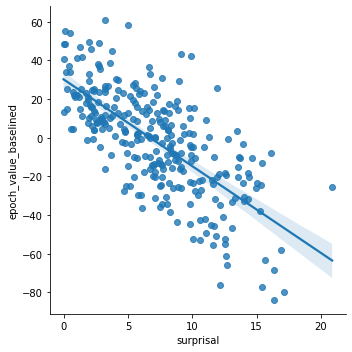

In [124]:
sns.lmplot(data=merged_df, x="surprisal", y="epoch_value_baselined")

In [125]:
st.pearsonr(merged_df.surprisal, merged_df.epoch_value_baselined)

(-0.7022246293306755, 1.0806704800669368e-44)